<figure>
  <center><img style='height: 80%; width: 80%; object-fit: contain' src="../images/slot_machine.jpg" /></center>
  <center><figcaption>The k-armed bandit problem is as if you were playing multiple slot machines at once</figcaption></center>
</figure>

In reinforcement learning (RL), the primary distinction between RL and supervised learning (SL) is that RL *evaluates* the actions of the bot rather than *instructing* it. SL simply indicates the correct action to be taken, regardless of the action taken, while RL indicates how good the action was. To study the evaluative aspect of RL, we will consider a simplified setting called the k-armed bandit problem.

In this problem, you are faced repeatedly with a choice among k different actions. After each choice, you receive a numerical reward chosen from a stationary probability density function that depends on the action you selected. Your goal is to maximize the expected total reward over a specified time period, such as 1000 time steps. 

The problem is named after the analogy to a slot machine (the "one-armed bandit"), except that it has k levers. Each action has an expected reward, referred to as its **value**. It's important to note that if you knew the value of each action, the problem would be solved because you would simply select the action with the greatest value. In practice we need to estimate the value, which is formally defined as:

$$ q_{*}(a) := \mathbf{E}[R_{t}|A_{t}=a] $$

Where $q_{*}(a)$ is the expected reward, given that action $a$ is selected. $R_{t}$ is the reward and $A_{t}$ is the action taken at time $t$. The subscript $*$ indicates that this is the true value, which is unknown to the agent but it is the value we are trying to estimate. In theory, if we knew the [joint probability distribution]({filename}../probability/pdfs.ipynb) of the rewards and actions, we could calculate the true value of each action. However, in practice, we only have access to the historical rewards and actions, and we must estimate the true value of each action.

One way to estimate the values of actions is to average the rewards seen when a particular action was taken (not necessarily the best way). This is known as an **action-value method**.

$$ Q_{t}(a) := \frac{\text{sum of rewards when $a$ taken prior to t}}{\text{number of times $a$ taken prior to t}} $$
$$ Q_{t}(a) = \frac{\sum_{i=1}^{t-1}R_{i}\cdot \boldsymbol{1}_{A_i=a}}{\sum_{i=1}^{t-1} \boldsymbol{1}_{A_{i}=a}} $$

Then, the simplest action selection rule is to choose the action with the highest estimated value, referred to as a greedy action.

$$A_{t} := \underset{a}{\mathrm{argmax}}Q_{t}(a) $$

 However, it is often beneficial to also explore non-greedy actions by selecting a random action with a small $\epsilon$ probability, known as an $\epsilon-greedy$ method. This ensures that all actions are sampled an infinite number of times, allowing the estimate of the value to converge to the true value.

To compare the performance of greedy and epsilon-greedy methods, Sutton provides a toy problem in his book where he analyzes a set of 2000 randomly generated k-armed bandit problems with k=10. The true values of the actions are selected from a normal distribution, and the reward for each action is also a normal distribution with a mean equal to the true value of the action. The learning agent is progressed over 1000 steps, referred to as one run, and this process is repeated 2000 times to effectively evaluate different bandit problems.

<figure>
  <center><img style='max-width:100%; height:auto' src="../images/multiarmed_bandit.JPG" /></center>
  <center><figcaption>Essentially each action is a associated with a reward distribution whose mean is the value. The centers of these distributions randomly change for each run</figcaption></center>
</figure>

What we see from such a simulation is that in the case of noisy rewards, the epsilon-greedy method performed better than the greedy method because it was able to explore more actions and improve its chances of finding the optimal action (see below). If there were no noise, the greedy method would perform best because it would quickly find the optimal action and stick to it. Overall, the epsilon-greedy method seemed to be the more robust choice, performing well in both noisy and less noisy environments. It is important to carefully consider the trade-off between exploration and exploitation in RL to achieve optimal performance.

<figure>
  <center><img style='max-width:100%; height:auto' src="../images/bandit_sim.JPG" /></center>
  <center><figcaption>It's clear that a little bit of exploration leads to higher average rewards and a higher percentage of decisions going to the optimal value decision</figcaption></center>
</figure>

### **Computational Implementation**

In order to calculate action values in a computationally efficient manner, we will consider a simple derivation. Let $R_i$ denote the reward received after the $ith$ selection of a particular action and let $Q_n$ denote the estimate of its action value after having been selected $n-1$ times. The formula for $Q_n$ is $Q_n = (R_1 + R_2 + ... + R_{n-1})/(n-1)$. However, we don't need to perform this computation over and over again. We can use the following update rule: 

$$Q_{n+1} = Q_n + (1/n)[R_n - Q_n]$$ 

The beauty of this is that it requires only computer memory for $Q_n$ and $n$. This update rule, also known as **incremental averaging**, is common and takes the form of: 

$$\text{New Estimate = Old Estimate + Step Size[Target - Old Estimate]}$$ 

In this case, the $\text{Target}$ is the nth reward and $\text{Target - Old Estimate}$ is an error estimate. Note that the Step Size gets smaller with increasing actions of this type taken.

Putting together the concepts of exploration-exploition via $\epsilon$-greedy methods and incremental averaging, we can implement a python function for the k-armed bandit RL agent as follows:

```python  
def k_armed_bandit(k, epsilon, runs, steps):
    # Initialize Q values to 0
    Q = np.zeros(k)
    # Initialize N values to 0
    N = np.zeros(k)
    # Initialize rewards to 0
    rewards = np.zeros(steps)
    # For each run
    for i in range(runs):
        # For each step
        for j in range(steps):
            # Select action based on epsilon greedy method
            if np.random.random() < epsilon:
                action = np.random.randint(k)
            else:
                action = np.argmax(Q)
            # Get reward from action
            reward = np.random.normal(loc=Q[action])
            # Update N and Q values
            N[action] += 1
            Q[action] += (1/N[action])*(reward - Q[action])
            # Update rewards
            rewards[j] += reward
    # Return average rewards
    return rewards/runs
```


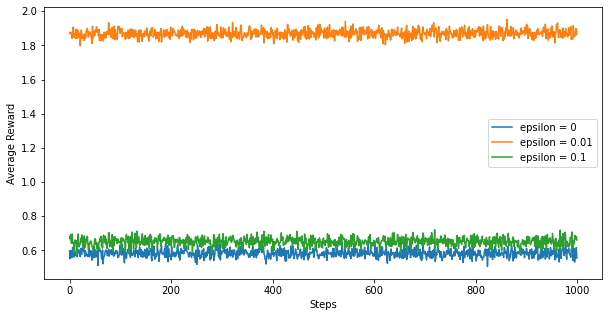

In [12]:
def k_armed_bandit(k, epsilon, runs, steps):
    # Initialize Q values to 0
    Q = np.zeros(k)
    # Initialize N values to 0
    N = np.zeros(k)
    # Initialize rewards to 0
    rewards = np.zeros(steps)
    # The "true" action values
    q = np.random.normal(loc=0, scale=1, size=k)
    # For each run
    for i in range(runs):
        # For each step
        for j in range(steps):
            # Select action based on epsilon greedy method
            if np.random.random() < epsilon:
                action = np.random.randint(k)
            else:
                action = np.argmax(Q)
            # Get reward from action
            reward = np.random.normal(loc=q[action])
            # Update N and Q values
            N[action] += 1
            Q[action] += (1/N[action])*(reward - Q[action])
            # Update rewards
            rewards[j] += reward

            # if j == 1:
            #     break
        
    # Return average rewards
    return rewards/runs

# lets now plot the average rewards for different values of epsilon
import matplotlib.pyplot as plt
import numpy as np
epsilons = [0, 0.01, 0.1]
runs = 2000
steps = 1000
k = 10
plt.figure(figsize=(10, 5))
for epsilon in epsilons:
    rewards = k_armed_bandit(k, epsilon, runs, steps)
    plt.plot(rewards, label='epsilon = ' + str(epsilon))
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend()
plt.show()


In [16]:
np.random.normal(loc=0, scale=1, size=k)

array([-1.10033146,  0.49455388, -0.77563885, -0.65280373,  0.1977862 ,
       -1.28521492,  0.94586784,  0.78648368,  1.14641256,  0.2043709 ])

When reward probabilities change over time, it makes sense to give more weight to recent rewards. It's common to modify the step size parameter to be constant for non-stationary reward probability density functions. In this case, Q<sub>n+1</sub> becomes a weighted average of the past rewards. This is known as an exponentially weighted average. For the constant α case, the value function estimates actually never converge for large n, but this is what we want in non-stationary problems.

In addition, the methods above depend on the initial action-value estimates, Q<sub>1</sub>(a). This is known as a biased estimate in statistics. For the sample-average method, the bias disappears once all actions have been selected at least once. But for a constant α, they persist. An initial bias in the value function, such as 5 in the k-armed bandit problem, is overly optimistic. But this over-optimism causes the algorithm to initially explore as it is disappointed in the rewards it is receiving. These optimistic initial values are good for encouraging exploration in stationary problems but not so in non-stationary problems since the exploration is only temporary in the beginning of the run.

In the epsilon-greedy algorithm, we can give preference to those actions which have some uncertainty and are close to being maximal. This can be captured with the following: A<sub>t</sub> = argmax[Q<sub>t</sub>(a) + c√(ln(t)/N<sub>t</sub>(a)] . This upper confidence bound action selection takes into account the uncertainty in the estimate of a's value. The quantity being indexed is essentially the upper bound of that action's value. As N<sub>t</sub>(a) increases, i.e. you've observed that action more, the uncertainty in its value decreases.

### **Sources**

Sutton, R. S., Barto, A. G. (2018). Reinforcement learning: An introduction (2nd ed.). MIT Press Ltd. 

White, M., White, A. (n.d.). *Reinforcement Learning Specialization* [MOOC]. Coursera.